# Context : Data cleaning, scaling, encoding, pipeline



Source : 



**Competition Description**




xxxx

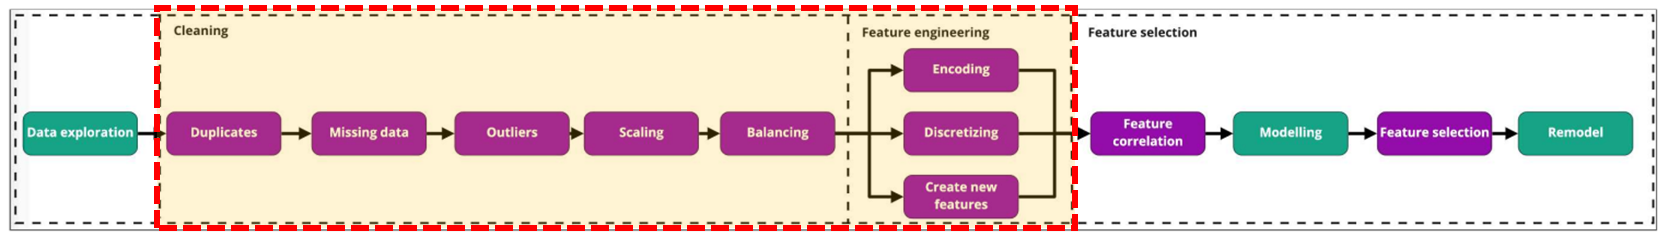



# Imports


In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

import os
import time
import pickle

import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from scipy.stats import iqr

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

# Models
from sklearn.model_selection import train_test_split


from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer



# Retrieve data


## Get the raw data



In [2]:
#Retrieve data
path_to_data = '../data/raw_data/'
data = pd.read_csv(path_to_data + 'train.csv')
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Train test split


In [3]:
# # Separating train set from test set
# train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

In [4]:
# # Display shapes
# print(f"Shape of train_set : {train_set.shape}")
# print(f"Shape of test_set : {test_set.shape}")

## Drop initial columns


In [5]:
#List the columns that won't be used (exemple : Id, Name, ...)
cols_to_drop = ['Id']

data = data.drop(columns=cols_to_drop)
data.shape

(1460, 80)

In [6]:
# Save initial number of columns
initial_number_cols = data.shape[1]
initial_number_cols

80

In [7]:
# list processed columns
processed = []
for col in cols_to_drop:
    processed.append(col)

processed

['Id']

# Cleaning Duplicates


In [8]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(data)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {data.duplicated().sum()}")

# Remove duplicates
# data = data.drop_duplicates() 

Number of rows : 1460
Number of duplicated rows : 0


# Cleaning Missing Data


<span style="font-family:Comic Sans MS; color:red">Let's check the missing data per column (in percentage) :  </span>


In [9]:
def get_missing_data(data):       
    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent
    return missing_data

missing_data = get_missing_data(data)
missing_data

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

## Missing values > Max_threshold



In [10]:
# Threshold for which we decide to drop the column
max_thres_missing = 90

# Retrieve the feature name of columns exceeding max threshold for missing values. 
high_missing_cols = missing_data[missing_data > 90].index.values.tolist()

high_missing_cols

['PoolQC', 'MiscFeature', 'Alley']

<span style="font-family:Comic Sans MS; color:red">If the missing values of a column exceeds a max threshold, we drop said columns from dataset :  </span>



In [11]:
# More than 90% is way too high, let's drop these features
for col in high_missing_cols:
    data.drop(columns=col, inplace=True)
    print(f"-- **{col}** has more than {max_thres_missing}% of missing values so {col} has been dropped from dataset\n")

-- **PoolQC** has more than 90% of missing values so PoolQC has been dropped from dataset

-- **MiscFeature** has more than 90% of missing values so MiscFeature has been dropped from dataset

-- **Alley** has more than 90% of missing values so Alley has been dropped from dataset



In [12]:
#List the columns that won't be used (exemple : Id, Name, ...)
for col in high_missing_cols:
    cols_to_drop.append(col)
    
cols_to_drop

['Id', 'PoolQC', 'MiscFeature', 'Alley']

In [13]:
print(f"We dropped the following columns : {high_missing_cols} ! ")

We dropped the following columns : ['PoolQC', 'MiscFeature', 'Alley'] ! 


In [14]:
# list processed columns
for col in high_missing_cols:
    processed.append(col)

processed

['Id', 'PoolQC', 'MiscFeature', 'Alley']

<span style="font-family:Comic Sans MS; color:red">Let's display the remaining missing data :  </span>



In [15]:
# Display the remaining missing data
missing_data = get_missing_data(data)
missing_data

Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
GarageYrBlt      5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtFinType1     2.534247
BsmtCond         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

In [16]:
# Determine type of missing columns
columns_missing = missing_data.index.values.tolist()
missing_cols_type = data[columns_missing].dtypes

#Identify the categorical columns with missing values
missing_cols_categorical = missing_cols_type[missing_cols_type == 'object'].index.values.tolist()
missing_cols_categorical;

#Identify the numerical columns with missing values
missing_cols_numerical = missing_cols_type[missing_cols_type != 'object'].index.values.tolist()
missing_cols_numerical;

<span style="font-family:Comic Sans MS; color:red">Let's display the categorical columns with missing values :  </span>




In [17]:
missing_cols_categorical

['Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond',
 'MasVnrType',
 'Electrical']

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns with missing values :  </span>

In [18]:
missing_cols_numerical

['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

### Missing values : Categorical columns


<span style="font-family:Comic Sans MS; color:red">/!\ It is important to check the meaning of a NAN value in the documentation !  </span>


<span style="font-family:Comic Sans MS; color:red"> NAN values that does not have signification in the following columns :  </span>




In [19]:
# Columns in which na rows must be dropped :
missing_rows_to_drop = ['MasVnrType','Electrical']  

In [20]:
# Drop Columns in which na rows
print(data.shape)
for col in missing_rows_to_drop:
    data.dropna(subset=col, axis=0, inplace=True)
print(data.shape)

(1460, 77)
(1451, 77)


In [21]:
# list processed columns
for col in missing_rows_to_drop:
    processed.append(col)

processed

['Id', 'PoolQC', 'MiscFeature', 'Alley', 'MasVnrType', 'Electrical']

In [22]:
# Remove cols with na rows to be dropped from other missing cols categorical
for col in missing_rows_to_drop:
    missing_cols_categorical.remove(col)
    
missing_cols_categorical

['Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond']

<span style="font-family:Comic Sans MS; color:red">/!\ If np.nan can be replaced by "NA", we use a simple imputer !  </span>



In [23]:
# Replace nan values by a replacement value
replace_value = "NA"

#Simple Imputer for nan values    
nan_imputer = SimpleImputer(missing_values = np.nan,          
                      strategy='constant', 
                      fill_value = replace_value)

In [24]:
#Check for unique values of each categorical col, 
#Replace nan values by a replacement value 
#and finally perform a value counts.
for col in missing_cols_categorical:
    print(f"-------------  {col}  ----------------------------------")
    print( f"Unique values: {data[col].unique()}\n")
    data[col] = nan_imputer.fit_transform(data[[col]])
    print(f"Nans have been replaced by {replace_value}.\n")
    print(data[col].value_counts()) 
    print(f"--------------------------------------------------------\n")

-------------  Fence  ----------------------------------
Unique values: [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']

Nans have been replaced by NA.

NA       1170
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64
--------------------------------------------------------

-------------  FireplaceQu  ----------------------------------
Unique values: [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']

Nans have been replaced by NA.

NA    685
Gd    378
TA    311
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
--------------------------------------------------------

-------------  GarageType  ----------------------------------
Unique values: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']

Nans have been replaced by NA.

Attchd     863
Detchd     387
BuiltIn     86
NA          81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
--------------------------------------------------------

-------------  GarageFinish  -----------------

In [25]:
# list processed columns
for col in missing_cols_categorical:
    processed.append(col)

processed

['Id',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'MasVnrType',
 'Electrical',
 'Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond']

### Missing values : Numerical columns


<span style="font-family:Comic Sans MS; color:red">Let's draw the histograms to have an idea of the distribution of the numerical columns that have missing values ! </span>




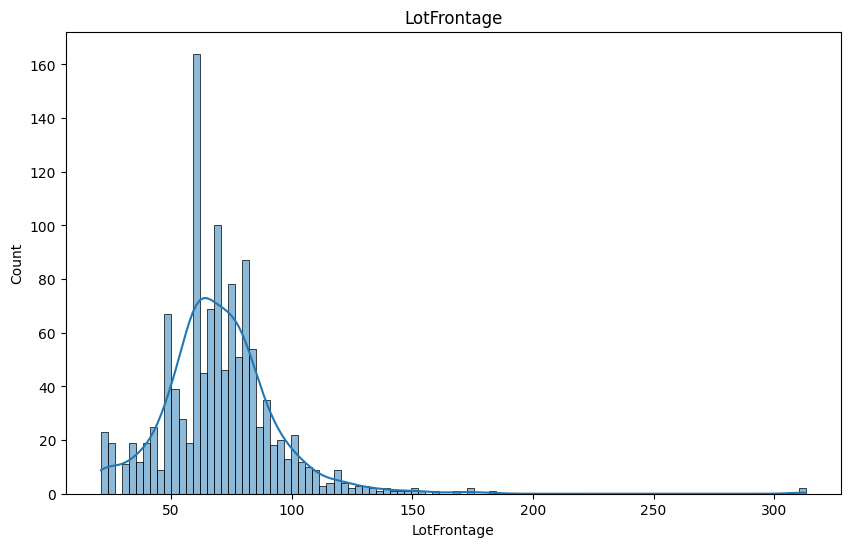

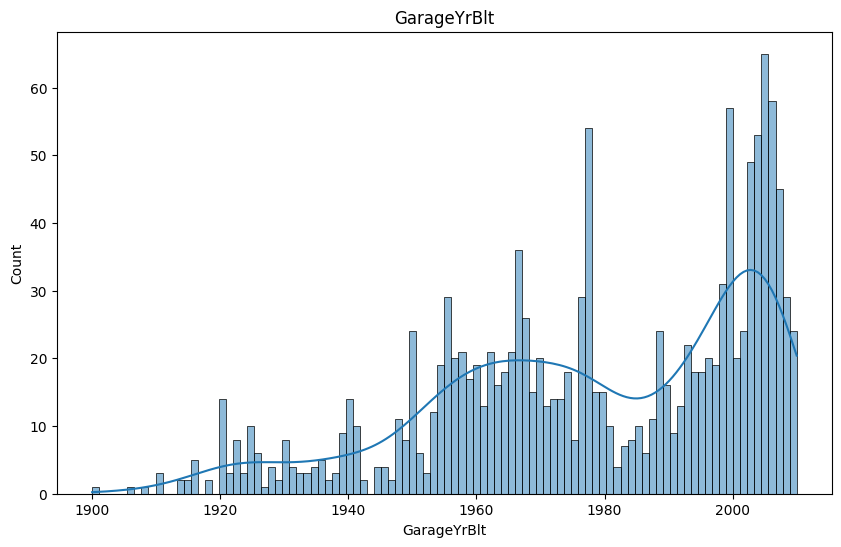

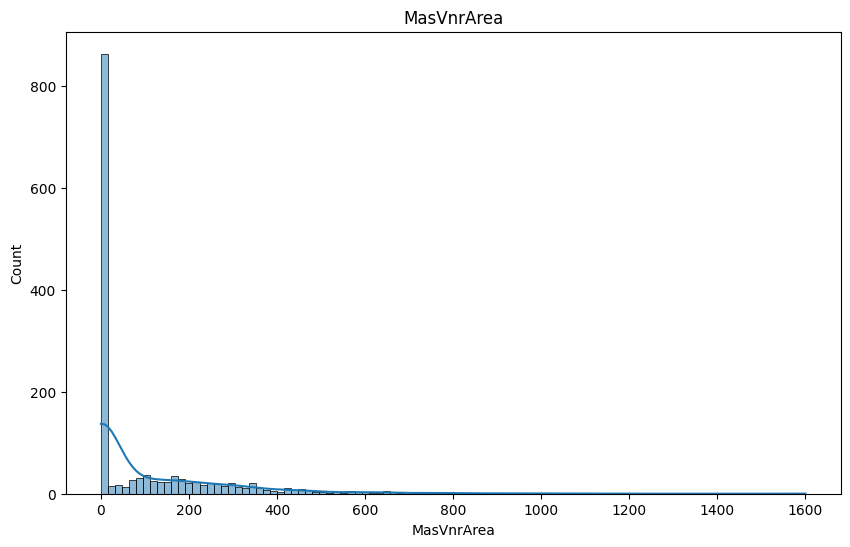

In [26]:
# Display hist plots for numerical features with missing values.
for col in missing_cols_numerical:   
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], kde=True, bins=100)   
    plt.title(f'{col}')
    

In [27]:
# Display statistics of numerical features with missing values.
for col in missing_cols_numerical:   
    print(f"-------------  {col}  ----------------------------------")
    print(data[col].describe())
    print(f"--------------------------------------------------------\n")
    

-------------  LotFrontage  ----------------------------------
count    1194.000000
mean       70.027638
std        24.299302
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64
--------------------------------------------------------

-------------  GarageYrBlt  ----------------------------------
count    1370.000000
mean     1978.353285
std        24.685798
min      1900.000000
25%      1961.000000
50%      1979.500000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64
--------------------------------------------------------

-------------  MasVnrArea  ----------------------------------
count    1451.00000
mean      103.75672
std       181.10815
min         0.00000
25%         0.00000
50%         0.00000
75%       166.00000
max      1600.00000
Name: MasVnrArea, dtype: float64
--------------------------------------------------------



#### Replace with mean value


<span style="font-family:Comic Sans MS; color:red"> We choose to impute the nan values by the mean value of the distribution ! </span>





<span style="font-family:Comic Sans MS; color:red"> /!\ Human input here : </span>






In [28]:
# List the columns with missing value to be replaced by MEAN value !
missing_cols_numerical_mean = ['LotFrontage']
mean_imputer = SimpleImputer(strategy='mean')

#Fit transform
for col in missing_cols_numerical_mean:
    data[col] = mean_imputer.fit_transform(data[[col]])   

In [29]:
# list processed columns
for col in missing_cols_numerical_mean:
    processed.append(col)

processed

['Id',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'MasVnrType',
 'Electrical',
 'Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond',
 'LotFrontage']

#### Replace by most_frequent

<span style="font-family:Comic Sans MS; color:red"> We choose to impute the nan values by the most frequent value of the distribution ! </span>






<span style="font-family:Comic Sans MS; color:red"> /!\ Human input here : </span>






In [30]:
# List the columns with missing value to be replaced by MOST FREQUENT value !
missing_cols_numerical_most_freq = ['MasVnrArea','GarageYrBlt']
most_frequent_imputer = SimpleImputer(strategy='most_frequent')

#Fit transform
for col in missing_cols_numerical_most_freq:
    data[col] = most_frequent_imputer.fit_transform(data[[col]])  

In [31]:
# list processed columns
for col in missing_cols_numerical_most_freq:
    processed.append(col)

processed


['Id',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'MasVnrType',
 'Electrical',
 'Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond',
 'LotFrontage',
 'MasVnrArea',
 'GarageYrBlt']

### Final check for missing values

In [32]:
# Display the remaining missing data
missing_data = get_missing_data(data)
missing_data

Series([], dtype: float64)

# Define X and y



In [33]:
# Define X and y
X = data.drop(columns='SalePrice')
y = data['SalePrice']


# Train test split


In [34]:
# Separating train set from test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
# Display shapes
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test : {y_test.shape}")


Shape of X_train : (1015, 76)
Shape of X_test : (436, 76)
Shape of y_train : (1015,)
Shape of y_test : (436,)


<span style="font-family:Comic Sans MS; color:red"> /!\ From now on, only use train data ! </span>







# Check outliers

In [36]:
# Extract numerical columns from original dataset
numerical_columns = X_train.select_dtypes(include = np.number).columns

## Visual check for outliers


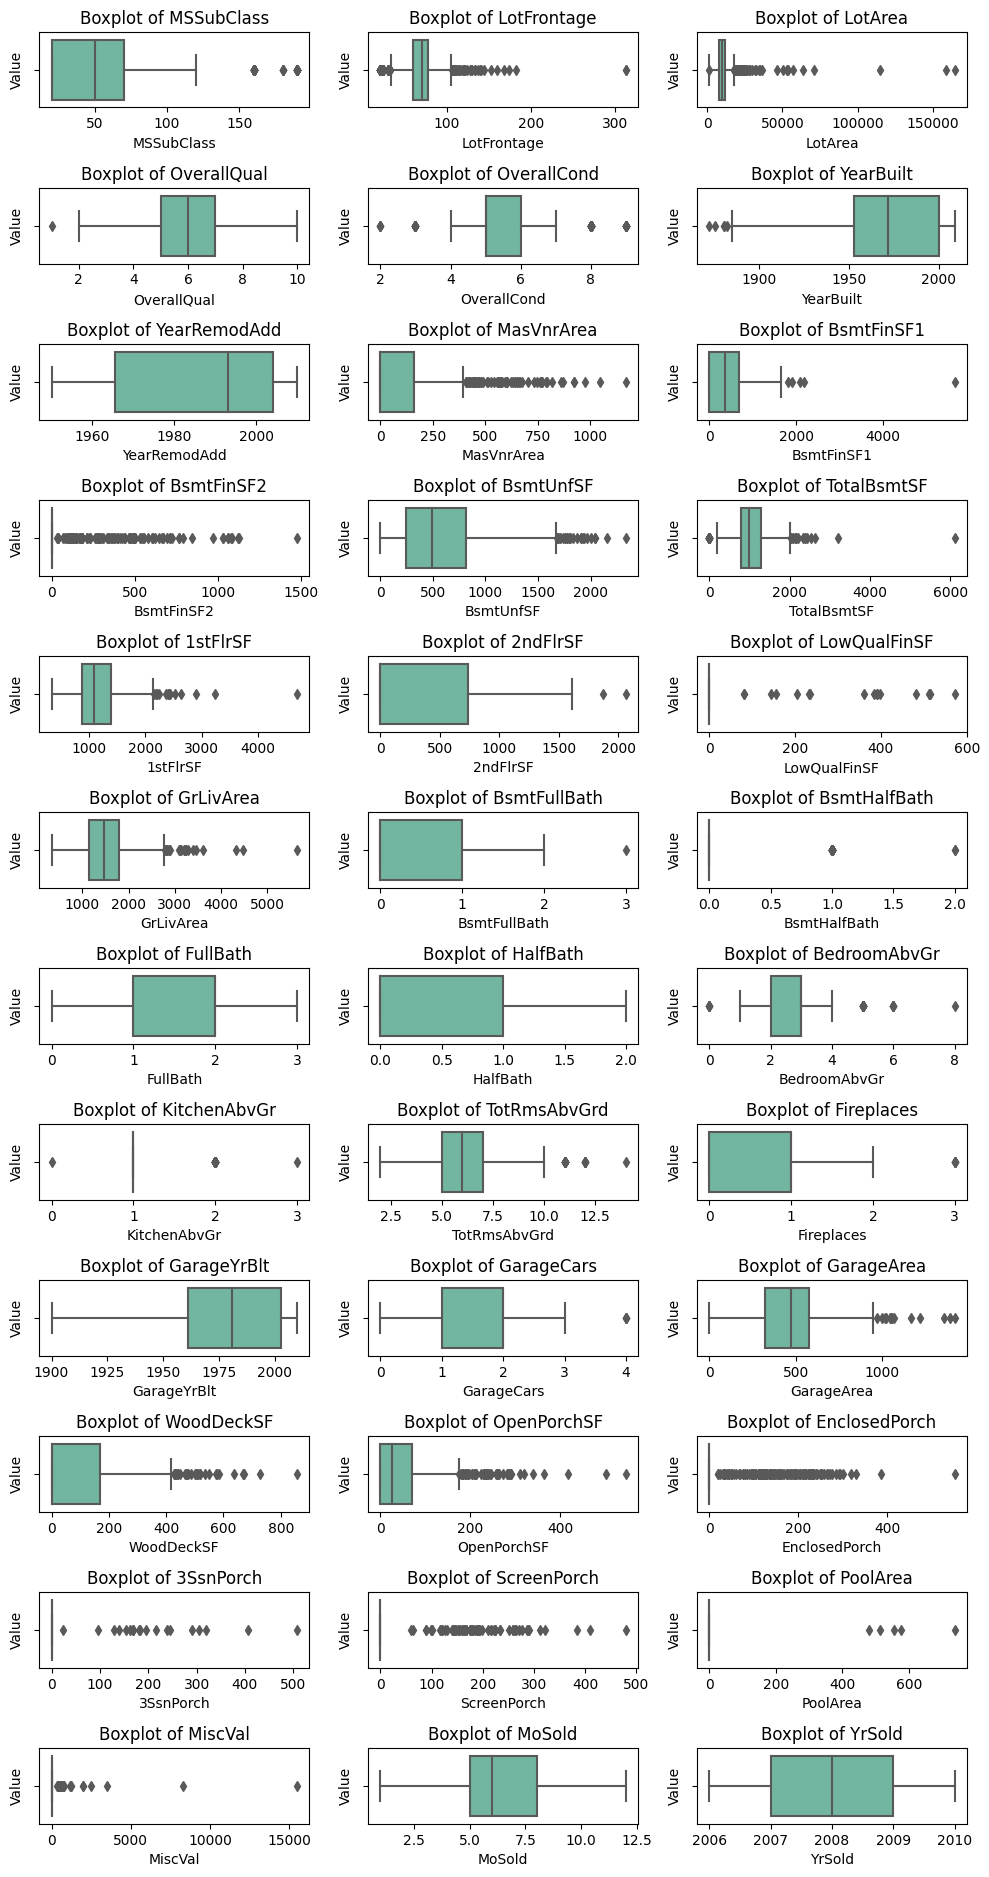

In [37]:
# Plot boxplots of each numerical column
plt.figure(figsize=(10, 20))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(13, 3, i)    
    sns.boxplot(x=X_train[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


<span style="font-family:Comic Sans MS; color:red">Plot a specific boxplot. Insert column name below : </span>


In [38]:
specific_column = 'MSSubClass'

Text(0, 0.5, 'Value')

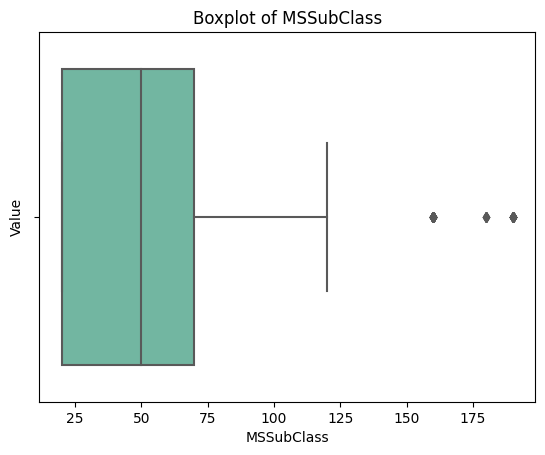

In [39]:
# Plot a specific boxplot
sns.boxplot(x=X_train[specific_column], palette='Set2')
plt.title(f'Boxplot of {specific_column}')
plt.xlabel(specific_column)
plt.ylabel('Value')

## Numerical check for outliers


<span style="font-family:Comic Sans MS; color:red"> Let's numerically extract the columns with outliers ! </span>


In [40]:
# Identify the columns with outliers
numerical_columns_w_outliers = []
numerical_columns_no_outliers = []

for col in numerical_columns: 
    # Calculate IQR
    iqr_value = iqr(X_train[col])

    #Calculate 1st quartile
    q1 = np.percentile(X_train[col],25)

    #Calculate 3rd quartile
    q3 = np.percentile(X_train[col],75)

    #Calculate lower limit below which data point is considered an outlier
    outlier_lim_low = q1 - 1.5 * iqr_value

    #Calculate higher limit above which data point is considered an outlier
    outlier_lim_high = q3 + 1.5 * iqr_value
    
    #Calculate number of 'low' outliers
    outlier_condition_low = X_train[col] < outlier_lim_low
    number_outliers_low = len(X_train[outlier_condition_low][col])
    
    #Calculate number of 'high' outliers
    outlier_condition_high = X_train[col] > outlier_lim_high
    number_outliers_high = len(X_train[outlier_condition_high][col])
    
    #Calculate total number of outliers
    number_outliers_total = number_outliers_low + number_outliers_high
    
#     print(f'------------------  {col}  -----------------------')
#     print(f'Number of outliers : {number_outliers_total}')
#     print('---------------------------------------------------')
    
    #If any outliers in column, column is added to a list of columns with outliers
    if number_outliers_total > 0:
        numerical_columns_w_outliers.append(col)
    elif number_outliers_total == 0:
        numerical_columns_no_outliers.append(col)

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns WITH outliers :  </span>



In [41]:
numerical_columns_w_outliers

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns WITHOUT outliers :  </span>



In [42]:
numerical_columns_no_outliers

['YearRemodAdd', 'FullBath', 'HalfBath', 'GarageYrBlt', 'MoSold', 'YrSold']

# Scaling




## Columns WITH outliers : Robust scaling




<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>




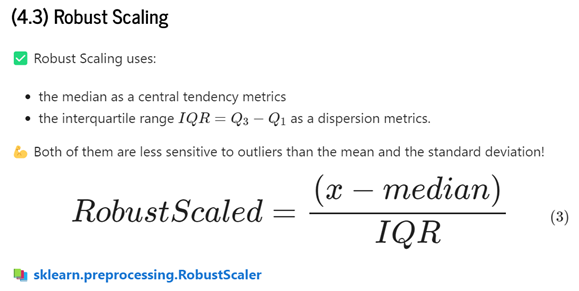


In [43]:
# Describe columns with outliers
X_train[numerical_columns_w_outliers].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,57.482759,69.764589,10621.660099,6.106404,5.570443,1970.436453,102.145813,423.509360,45.647291,583.799015,1052.955665,1160.497537,361.174384,5.565517,1527.237438,0.403941,0.056158,2.879803,1.046305,6.541872,0.628571,1.759606,470.630542,96.058128,47.577340,22.162562,4.230542,14.504433,2.818719,52.226601
std,42.476858,22.619873,9606.924164,1.391900,1.109717,30.671892,175.347619,457.048459,161.985894,452.603615,438.926120,388.896116,440.380681,47.299889,530.886005,0.516383,0.238749,0.828092,0.219430,1.637206,0.654955,0.746685,212.417095,129.845021,65.864002,62.067090,33.416534,54.923811,40.569475,583.859809
min,20.000000,21.000000,1300.000000,1.000000,2.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7549.000000,5.000000,5.000000,1953.000000,0.000000,0.000000,0.000000,244.500000,794.000000,878.000000,0.000000,0.000000,1134.000000,0.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,323.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,70.027638,9588.000000,6.000000,5.000000,1972.000000,0.000000,360.000000,0.000000,490.000000,993.000000,1090.000000,0.000000,0.000000,1466.000000,0.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,474.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,78.000000,11600.000000,7.000000,6.000000,2000.000000,162.000000,688.000000,0.000000,816.000000,1284.000000,1382.500000,740.000000,0.000000,1792.000000,1.000000,0.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,190.000000,313.000000,164660.000000,10.000000,9.000000,2009.000000,1170.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


In [44]:
#Instanciate, fit, transform with robust scaler
rb_scaler = RobustScaler()
X_train[numerical_columns_w_outliers] = rb_scaler.fit_transform(X_train[numerical_columns_w_outliers])

In [45]:
# Describe columns with outliers after robust scaling
X_train[numerical_columns_w_outliers].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,0.149655,-0.014614,0.255162,0.053202,0.570443,-0.033267,0.630530,0.092310,45.647291,0.164128,0.122359,0.139737,0.488073,5.565517,0.093066,0.403941,0.056158,-0.120197,0.046305,0.270936,-0.371429,-0.240394,-0.013318,0.571775,0.293962,22.162562,4.230542,14.504433,2.818719,52.226601
std,0.849537,1.256660,2.371494,0.695950,1.109717,0.652593,1.082393,0.664315,161.985894,0.791957,0.895768,0.770855,0.595109,47.299889,0.806818,0.516383,0.238749,0.828092,0.219430,0.818603,0.654955,0.746685,0.839593,0.772887,0.940914,62.067090,33.416534,54.923811,40.569475,583.859809
min,-0.600000,-2.723758,-2.045915,-2.500000,-3.000000,-2.127660,0.000000,-0.523256,0.000000,-0.857393,-2.026531,-1.498513,0.000000,0.000000,-1.720365,0.000000,0.000000,-3.000000,-1.000000,-2.000000,-1.000000,-2.000000,-1.873518,0.000000,-0.385714,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.600000,-0.557091,-0.503333,-0.500000,0.000000,-0.404255,0.000000,-0.523256,0.000000,-0.429571,-0.406122,-0.420218,0.000000,0.000000,-0.504559,0.000000,0.000000,-1.000000,0.000000,-0.500000,-1.000000,-1.000000,-0.596838,0.000000,-0.385714,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.400000,0.442909,0.496667,0.500000,1.000000,0.595745,1.000000,0.476744,0.000000,0.570429,0.593878,0.579782,1.000000,0.000000,0.495441,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.403162,1.000000,0.614286,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.800000,13.498465,38.279931,2.000000,4.000000,0.787234,7.222222,7.680233,1474.000000,3.230096,10.442857,7.139742,2.790541,572.000000,6.346505,3.000000,2.000000,5.000000,2.000000,4.000000,2.000000,2.000000,3.731225,5.101190,7.428571,552.000000,508.000000,480.000000,738.000000,15500.000000


In [46]:
# list processed columns
for col in numerical_columns_w_outliers:
    processed.append(col)

## Columns WITHOUT outliers



### Quick visual check




<span style="font-family:Comic Sans MS; color:red">Quick visual check for columns WITHOUT outliers !  </span>


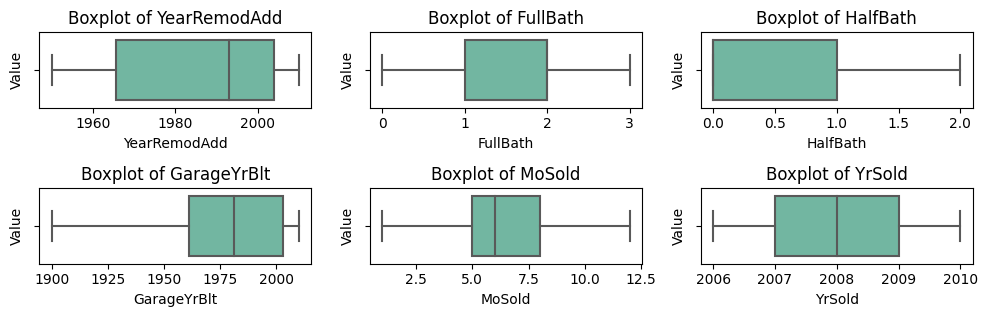

In [47]:
# display boxplots of columns with no outliers
plt.figure(figsize=(10, 20))

for i, column in enumerate(numerical_columns_no_outliers, 1):
    plt.subplot(13, 3, i)    
    sns.boxplot(x=X_train[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

### Distribution of columns WITHOUT outliers



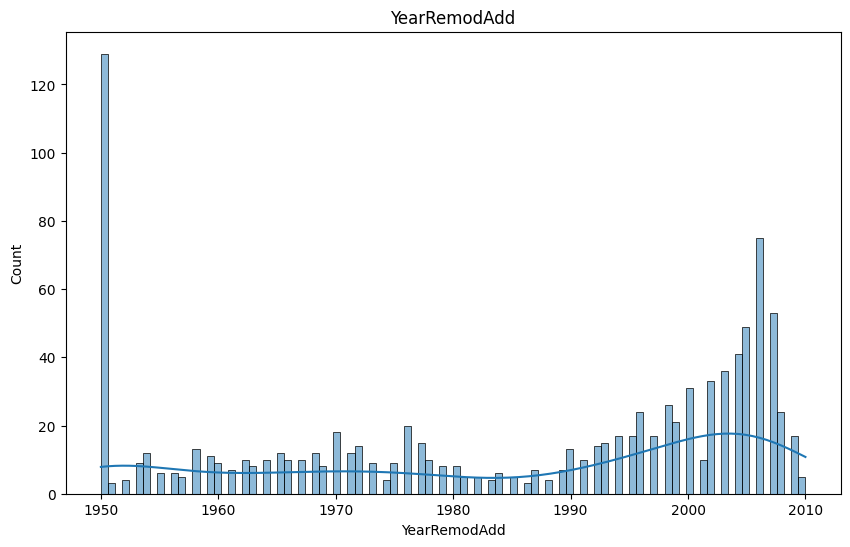

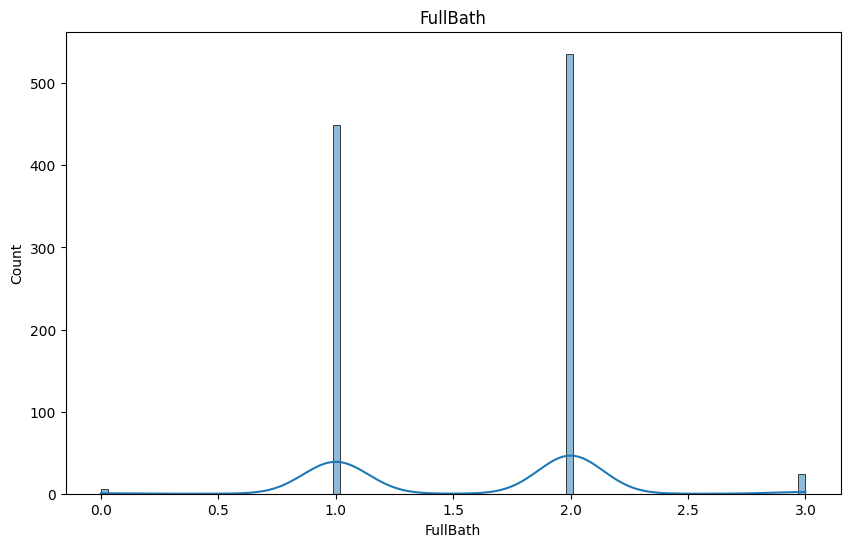

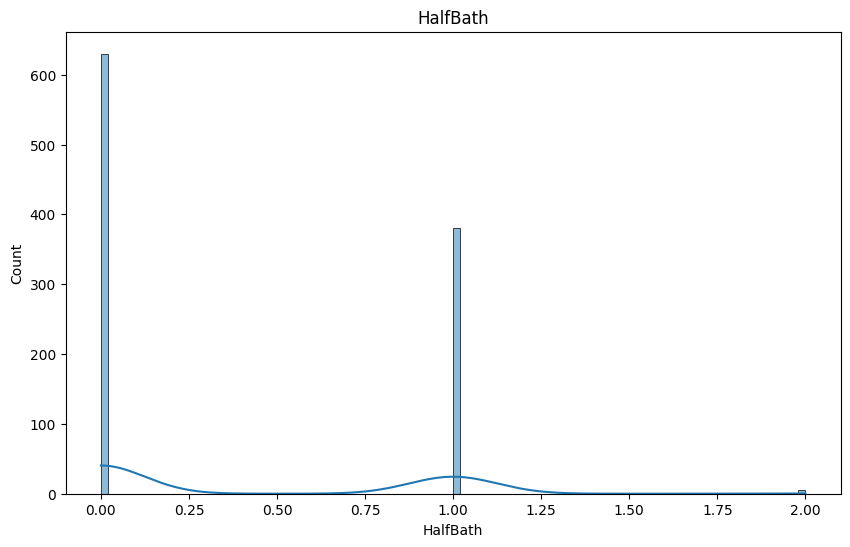

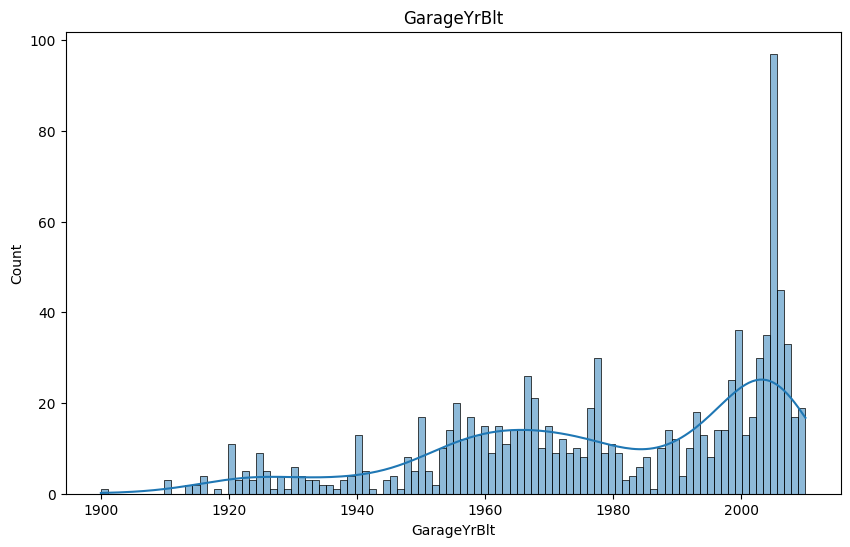

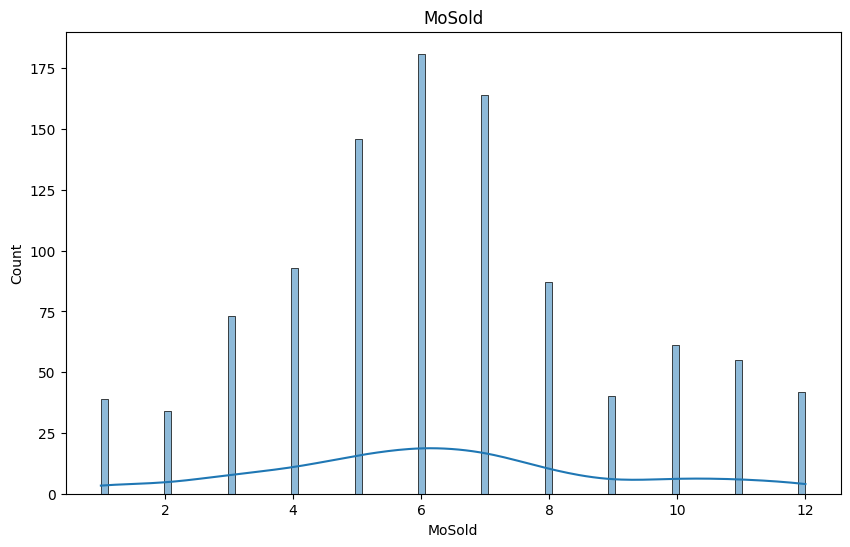

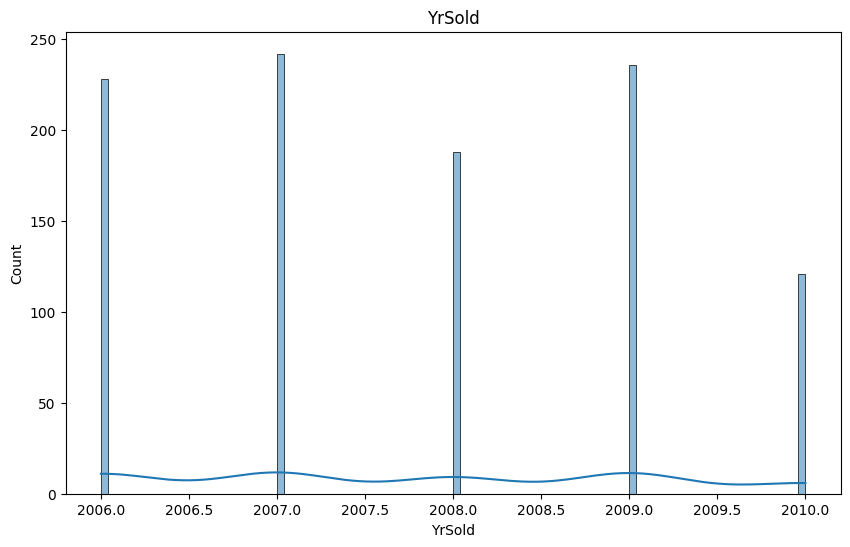

In [48]:
# Display hist plots for numerical features with no outliers.
for col in numerical_columns_no_outliers:
    plt.figure(figsize=(10, 6))
    sns.histplot(X_train[col], kde=True, bins=100)   
    plt.title(f'{col}')
    

###  Implement Minmax Scaling



<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>




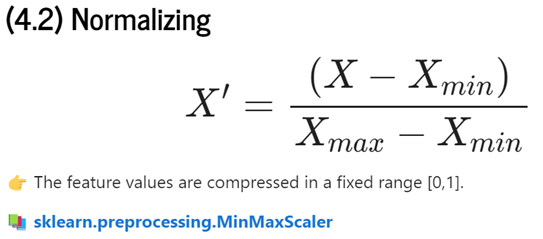


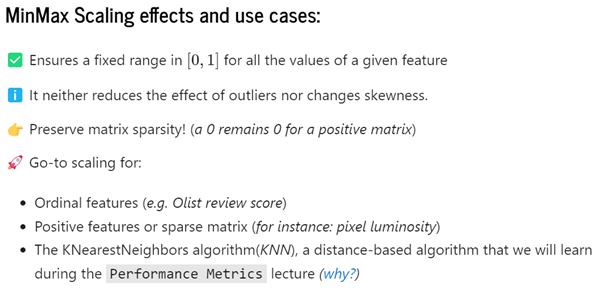


In [49]:
# Describe columns with NO outliers
X_train[numerical_columns_no_outliers].describe()

,YearRemodAdd,FullBath,HalfBath,GarageYrBlt,MoSold,YrSold
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,1984.391133,1.569458,0.384236,1978.971429,6.341872,2007.783251
std,20.877536,0.551896,0.496683,25.270571,2.685040,1.342051
min,1950.000000,0.000000,0.000000,1900.000000,1.000000,2006.000000
25%,1965.500000,1.000000,0.000000,1961.000000,5.000000,2007.000000
50%,1993.000000,2.000000,0.000000,1981.000000,6.000000,2008.000000
75%,2004.000000,2.000000,1.000000,2003.000000,8.000000,2009.000000
max,2010.000000,3.000000,2.000000,2010.000000,12.000000,2010.000000


In [50]:
#Instanciate, fit, transform with minmax scaler
minmax_scaler = MinMaxScaler()
X_train[numerical_columns_no_outliers] = minmax_scaler.fit_transform(X_train[numerical_columns_no_outliers])

In [51]:
# Describe columns with NO outliers after minmax scaling
X_train[numerical_columns_no_outliers].describe()

,YearRemodAdd,FullBath,HalfBath,GarageYrBlt,MoSold,YrSold
count,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000,1015.000000
mean,0.573186,0.523153,0.192118,0.717922,0.485625,0.445813
std,0.347959,0.183965,0.248342,0.229732,0.244095,0.335513
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258333,0.333333,0.000000,0.554545,0.363636,0.250000
50%,0.716667,0.666667,0.000000,0.736364,0.454545,0.500000
75%,0.900000,0.666667,0.500000,0.936364,0.636364,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# list processed columns
for col in numerical_columns_no_outliers:
    processed.append(col)

# Balancing

<span style="font-family:Comic Sans MS; color:red"> TO BE DEFINED !  </span>





# Encoding


In [53]:
# Extract categorical columns from original dataset
categorical_columns = X_train.select_dtypes(include = 'object').columns
categorical_columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

## One hot encoder


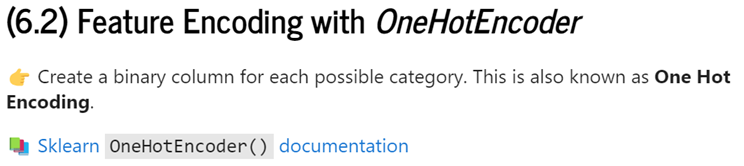


<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY extract the categorical columns that will be OneHotEncoded !  </span>







<span style="font-family:Comic Sans MS; color:red"> /!\ It is necessary to read the associated documentation !  </span>








In [54]:
# Categorical columns to be encoded with OneHotEncoder
categorical_columns_ohe = ['MSZoning', 'Street','LotShape',
                           'LandContour','Utilities','LotConfig','LandSlope',
                           'Neighborhood','Condition1','Condition2','BldgType',
                           'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st',
                           'Exterior2nd','MasVnrType','Foundation','Heating', 
                           'CentralAir','Electrical','Functional','GarageType',
                           'PavedDrive','Fence','SaleType','SaleCondition']


In [55]:
# Instantiate, fit
ohe_encoder = OneHotEncoder(sparse_output=False,drop = 'if_binary')
ohe_encoder.fit(X_train[categorical_columns_ohe])

#Transform 
X_train[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(X_train[categorical_columns_ohe]);
print(X_train.shape)

#Drop initial features
X_train.drop(columns=categorical_columns_ohe, inplace=True)
print(X_train.shape)


(1015, 255)
(1015, 228)


In [56]:
# list processed columns
for col in categorical_columns_ohe:
    processed.append(col)

## Ordinal encoder


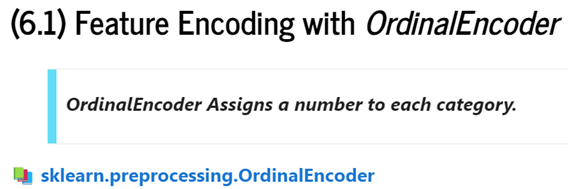


<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY extract the categorical columns that will be Encoded Ordinally !  </span>








<span style="font-family:Comic Sans MS; color:red"> /!\ It is necessary to read the associated documentation !  </span>








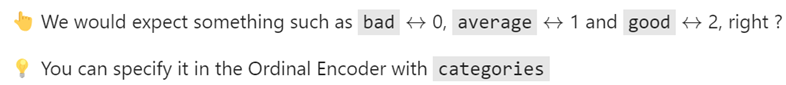


In [57]:
# Categorical columns to be encoded with OrdinalEncoder
categorical_columns_ordinal = ['ExterQual','ExterCond','BsmtQual','BsmtCond', 
                               'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
                               'KitchenQual','FireplaceQu','GarageFinish','GarageQual',
                               'GarageCond']

In [58]:
# Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

ExterQual_cat = ['Po','Fa','TA','Gd','Ex']
ExterCond_cat = ['Po','Fa','TA','Gd','Ex']

BsmtQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
BsmtCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

BsmtExposure_cat = ['NA','No','Mn','Av','Gd']

BsmtFinType1_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
BsmtFinType2_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']

HeatingQC_cat = ['Po','Fa','TA','Gd','Ex']
KitchenQual_cat = ['Po','Fa','TA','Gd','Ex']

FireplaceQu_cat = ['NA','Po','Fa','TA','Gd','Ex']

GarageFinish_cat = ['NA','Unf','RFn','Fin']

GarageQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
GarageCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

ordered_categories = [ExterQual_cat, ExterCond_cat,BsmtQual_cat,BsmtCond_cat,
                      BsmtExposure_cat, BsmtFinType1_cat, BsmtFinType2_cat,
                      HeatingQC_cat, KitchenQual_cat, FireplaceQu_cat,
                      GarageFinish_cat, GarageQual_cat, GarageCond_cat]


In [59]:
# Instantiate, fit using ordinal encoding
ordinal_encoder = OrdinalEncoder(categories = ordered_categories)
ordinal_encoder.fit(X_train[categorical_columns_ordinal]);

#Transform
X_train[ordinal_encoder.get_feature_names_out()] = ordinal_encoder.transform(X_train[categorical_columns_ordinal])

print(X_train.shape)

(1015, 228)


In [60]:
# list processed columns
for col in categorical_columns_ordinal:
    processed.append(col)

# Check all columns have been processed


In [61]:
# Check that initial columns have all been adressed : 
len(np.unique(processed)) == initial_number_cols

True

# Final pipeline





In [62]:
#Retrieve data
path_to_data = '../data/raw_data/'
data = pd.read_csv(path_to_data + 'train.csv')
data.head();

In [63]:
# Define X and y
X = data.drop(columns='SalePrice')
y = data['SalePrice']

In [64]:
# Separating train set from test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display shapes
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test : {y_test.shape}")

Shape of X_train : (1022, 80)
Shape of X_test : (438, 80)
Shape of y_train : (1022,)
Shape of y_test : (438,)


In [65]:
# Columns in which na rows must be dropped :
missing_rows_to_drop = ['MasVnrType','Electrical']

# Drop Columns in which na rows
print(f"Shape of X_train before : {X_train.shape}")
print(f"Shape of X_test before : {X_train.shape}")
      
for col in missing_rows_to_drop:
    X_train.dropna(subset=col, axis=0, inplace=True)
    X_test.dropna(subset=col, axis=0, inplace=True)
      
print(f"Shape of X_train after : {X_train.shape}")
print(f"Shape of X_test after : {X_train.shape}")

Shape of X_train before : (1022, 80)
Shape of X_test before : (1022, 80)
Shape of X_train after : (1018, 80)
Shape of X_test after : (1018, 80)


## Listing the columns


In [66]:
#List the columns that won't be used (exemple : Id, Name, ...)
cols_to_drop = ['Id', 'PoolQC', 'MiscFeature', 'Alley']

# Columns in which na rows must be dropped :
missing_rows_to_drop = ['MasVnrType','Electrical']

# categorical columns with missing values
missing_cols_categorical = ['Fence', 'FireplaceQu', 'GarageType', 'GarageFinish',
                            'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure',
                            'BsmtQual', 'BsmtFinType1', 'BsmtCond']

# List the columns with missing value to be replaced by MEAN value !
missing_cols_numerical_mean = ['LotFrontage']

# List the columns with missing value to be replaced by MOST FREQUENT value !
missing_cols_numerical_most_freq = ['MasVnrArea','GarageYrBlt']

# numerical columns with outliers
numerical_columns_w_outliers = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
                                'YearBuilt','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                                'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                                'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
                                'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
                                'WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                                'PoolArea','MiscVal']

# numerical columns without outliers
numerical_columns_no_outliers = ['YearRemodAdd', 'FullBath', 'HalfBath', 'MoSold', 'YrSold']

# Categorical columns to be encoded with OneHotEncoder
categorical_columns_ohe = ['MSZoning', 'Street','LotShape',
                           'LandContour','Utilities','LotConfig','LandSlope',
                           'Neighborhood','Condition1','Condition2','BldgType',
                           'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st',
                           'Exterior2nd','MasVnrType','Foundation','Heating', 
                           'CentralAir','Electrical','Functional','GarageType',
                           'PavedDrive','Fence','SaleType','SaleCondition']

# Categorical columns to be encoded with OrdinalEncoder
categorical_columns_ordinal = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                             'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond']

# Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

ExterQual_cat = ['Po','Fa','TA','Gd','Ex']
ExterCond_cat = ['Po','Fa','TA','Gd','Ex']

BsmtQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
BsmtCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

BsmtExposure_cat = ['NA','No','Mn','Av','Gd']

BsmtFinType1_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
BsmtFinType2_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']

HeatingQC_cat = ['Po','Fa','TA','Gd','Ex']
KitchenQual_cat = ['Po','Fa','TA','Gd','Ex']

FireplaceQu_cat = ['NA','Po','Fa','TA','Gd','Ex']

GarageFinish_cat = ['NA','Unf','RFn','Fin']

GarageQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
GarageCond_cat = ['NA','Po','Fa','TA','Gd','Ex']


ordered_categories = {
                        'ExterQual_cat' : ['Po','Fa','TA','Gd','Ex'],
                        'ExterCond_cat' : ['Po','Fa','TA','Gd','Ex'],

                        'BsmtQual_cat' : ['NA','Po','Fa','TA','Gd','Ex'],
                        'BsmtCond_cat' : ['NA','Po','Fa','TA','Gd','Ex'],

                        'BsmtExposure_cat' : ['NA','No','Mn','Av','Gd'],

                        'BsmtFinType1_cat' : ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],
                        'BsmtFinType2_cat' : ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],

                        'HeatingQC_cat' : ['Po','Fa','TA','Gd','Ex'],
                        'KitchenQual_cat' : ['Po','Fa','TA','Gd','Ex'],

                        'FireplaceQu_cat' : ['NA','Po','Fa','TA','Gd','Ex'],

                        'GarageFinish_cat' : ['NA','Unf','RFn','Fin'],

                        'GarageQual_cat' : ['NA','Po','Fa','TA','Gd','Ex'],
                        'GarageCond_cat' : ['NA','Po','Fa','TA','Gd','Ex']
    
                    }

In [67]:
#  Lists renaming for clarity purpose
simple_imp_na = missing_cols_categorical
simple_imp_mean = missing_cols_numerical_mean
simple_imp_mf = missing_cols_numerical_most_freq
imp_remainer = []

rb_scaler = numerical_columns_w_outliers
minmax = numerical_columns_no_outliers
ohe = categorical_columns_ohe
ordinal = categorical_columns_ordinal

In [68]:
# Check all the columns to be IMPUTED (+remainder not imputed)
simple = [simple_imp_na, simple_imp_mean, simple_imp_mf]
temp = X_train.columns.tolist()

# Check remaining columns that have not been imputed
print(f"Initial number of columns : {len(temp)}")
for liste in simple:
    for element in liste:
        temp.remove(element)
print(f"Number of columns not imputed : {len(temp)}")

# Create column list for non imputed features
imp_remainer = temp

# Add all the columns together to check that all cols have been reviewed
simple = [simple_imp_na, simple_imp_mean, simple_imp_mf, imp_remainer]

# Check number of columns
total = 0
for lis in simple:
    total = total + len(lis)
print(f"Number of columns 'Imputed' AND 'NOT Imputed' : {total}")


Initial number of columns : 80
Number of columns not imputed : 66
Number of columns 'Imputed' AND 'NOT Imputed' : 80


In [69]:
# Check all the columns performing SCALING + ENCODING (+remainder not scaled or encoded)
scale = [rb_scaler, minmax, ohe, ordinal]
temp = X_train.columns.tolist()

# Check remaining columns that have not been scaled or encoded
print(f"Initial number of columns : {len(temp)}")
for liste in scale:
    for element in liste:
        temp.remove(element)
print(f"Number of columns not scaled or encoded : {len(temp)}")
temp
scale_remainer = temp
scale = [rb_scaler, minmax, ohe, ordinal,scale_remainer]

total = 0
for lis in scale:
    total = total + len(lis)
print(f"Number of columns 'Scaled or Encoded' AND 'NOT Scaled or Encoded' : {total}")


Initial number of columns : 80
Number of columns not scaled or encoded : 4
Number of columns 'Scaled or Encoded' AND 'NOT Scaled or Encoded' : 80


In [70]:
# Create a dictionary with the imputing actions to be performed on columns 
dict_imp = {'sim_imp_na' : simple_imp_na,
           'sim_imp_mean' : simple_imp_mean,
           'sim_imp_mf' : simple_imp_mf,
           'imp_remainer' : imp_remainer}

# Create a dictionary with the scaling and encoding actions to be performed on columns 
dict_sc_enc = {'rb_scaler': rb_scaler,
                'minmax': minmax,
                'ohe': ohe,
                'ordinal': ordinal,
                'scale_remainer' : scale_remainer}

## Columns intersection btw imputing and scaling_encoding



<span style="font-family:Comic Sans MS; color:red"> Create a dict that separate columns based on imputing actions and scaling/encoding actions !  </span>


In [71]:
# Python program to illustrate the intersection of two lists using set() method
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

# Create a dict that separate columns based on imputing actions and scaling/encoding actions.
dict = {}
for key_i, value_i in dict_imp.items():
    for key, value in dict_sc_enc.items():   
        inter = intersection(value_i, value)
        if len(inter) > 0:
#             print(f"-- {key_i}__{key} : {inter}\n")
            dict[f"{key_i}__{key}"] = inter        

## Create intermediate pipelines


In [72]:
# Create pipelines
# ************************************************************************************************************************
# sim_imp_na__ohe : Pipeline with simple imputer ("NA" value) and one hot encoding
sim_imp_na__ohe_p = make_pipeline(SimpleImputer(missing_values = np.nan,
                                                strategy='constant',
                                                fill_value = "NA"),
                                OneHotEncoder(sparse_output=False,
                                              drop = 'if_binary',
                                              handle_unknown='ignore'))
# ************************************************************************************************************************

# ************************************************************************************************************************
# sim_imp_na__ordinal : Pipeline with simple imputer ("NA" value) and ordinal encoding 

# -----------------------------------------------------------------------------------------------
# Create a list of ordered categories based on the ordered columns fed to the ordinal encoder
ordered_categories_sim_imp_na__ordinal_p =[]
for element in dict['sim_imp_na__ordinal']:
    ordered_categories_sim_imp_na__ordinal_p.append(ordered_categories[f"{element}_cat"])
# -----------------------------------------------------------------------------------------------

sim_imp_na__ordinal_p = make_pipeline(SimpleImputer(missing_values = np.nan,
                                                    strategy='constant',
                                                    fill_value = "NA"),
                                     OrdinalEncoder(categories = ordered_categories_sim_imp_na__ordinal_p))
# ************************************************************************************************************************

# ************************************************************************************************************************
# sim_imp_mean__rb_scaler : Pipeline with simple imputer (mean value) and Robust Scaling
sim_imp_mean__rb_scaler_p = make_pipeline(SimpleImputer(strategy='mean'),RobustScaler())
# ************************************************************************************************************************

# ************************************************************************************************************************
# sim_imp_mf__rb_scaler : Pipeline with simple imputer (most frequent value) and Robust Scaling
sim_imp_mf__rb_scaler_p = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                        RobustScaler())
# ************************************************************************************************************************

# ************************************************************************************************************************
# imp_remainer__rb_scaler : Just a Robust Scaler
imp_remainer__rb_scaler_p = RobustScaler()
# ************************************************************************************************************************

# ************************************************************************************************************************
# imp_remainer__minmax : Just a MinMax Scaler
imp_remainer__minmax_p = MinMaxScaler()
# ************************************************************************************************************************

# ************************************************************************************************************************
# imp_remainer__ohe : Just one hot encoder
imp_remainer__ohe_p = OneHotEncoder(sparse_output=False,
                                    drop = 'if_binary',
                                    handle_unknown='ignore')
# ************************************************************************************************************************

# ************************************************************************************************************************
# imp_remainer__ordinal : Just ordinal encoding
# -----------------------------------------------------------------------------------------------
# Create a list of ordered categories based on the ordered columns fed to the ordinal encoder
ordered_categories_imp_remainer__ordinal =[]
for element in dict['imp_remainer__ordinal']:
    ordered_categories_imp_remainer__ordinal.append(ordered_categories[f"{element}_cat"])
# -----------------------------------------------------------------------------------------------
imp_remainer__ordinal_p = OrdinalEncoder(categories = ordered_categories_imp_remainer__ordinal)
# ************************************************************************************************************************

# ************************************************************************************************************************
# imp_remainer__scale_remainer 
# imp_remainer__scale_remainer_p = ??
# ************************************************************************************************************************

## Create column transformer


In [73]:
preproc_basic = make_column_transformer(
        ('drop',cols_to_drop),
        (sim_imp_na__ohe_p,           dict['sim_imp_na__ohe']),
        (sim_imp_na__ordinal_p,       dict['sim_imp_na__ordinal']),
        (sim_imp_mean__rb_scaler_p,   dict['sim_imp_mean__rb_scaler']),
        (sim_imp_mf__rb_scaler_p,     dict['sim_imp_mf__rb_scaler']),
        (imp_remainer__rb_scaler_p,   dict['imp_remainer__rb_scaler']),
        (imp_remainer__minmax_p,      dict['imp_remainer__minmax']),
        (imp_remainer__ohe_p,         dict['imp_remainer__ohe']),
        (imp_remainer__ordinal_p,     dict['imp_remainer__ordinal']),
        remainder='passthrough',
        verbose_feature_names_out =False)

preproc_basic.set_output(transform="pandas")
result = preproc_basic.fit_transform(X_train)

print(result.shape)
result

(1018, 226)


,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,BsmtFinType1,BsmtQual,BsmtFinType2,GarageQual,GarageFinish,FireplaceQu,BsmtCond,GarageCond,BsmtExposure,LotFrontage,MasVnrArea,GarageYrBlt,PoolArea,MSSubClass,GrLivArea,YearBuilt,BedroomAbvGr,GarageArea,GarageCars,BsmtFinSF1,3SsnPorch,BsmtHalfBath,Fireplaces,1stFlrSF,LowQualFinSF,OverallQual,BsmtUnfSF,BsmtFullBath,ScreenPorch,EnclosedPorch,LotArea,TotalBsmtSF,OpenPorchSF,MiscVal,TotRmsAbvGrd,OverallCond,2ndFlrSF,BsmtFinSF2,WoodDeckSF,KitchenAbvGr,MoSold,YearRemodAdd,HalfBath,YrSold,FullBath,Street_Pave,CentralAir_Y,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Utilities_NoSeWa,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,PavedDrive_N,PavedDrive_P,PavedDrive_Y,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HeatingQC,ExterQual,KitchenQual,ExterCond
135,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,3.0,1.0,4.0,3.0,3.0,1.0,0.504793,1.694118,-0.365854,0.0,-0.6,0.315789,-0.041667,0.0,0.202867,0.0,-0.536653,0.0,0.0,0.0,1.171,0.0,0.5,1.394043,0.0,0.0,0.0,0.193435,0.615845,-0.369863,0.0,0.5,1.0,0.000000,0.0,0.574780,0.0,0.363636,0.333333,0.0,0.50,0.666667,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [74]:
# res_df = pd.DataFrame(preproc_basic.transform(X_train), columns=preproc_basic.get_feature_names_out())
# print(res_df.shape)
# res_df.head()

# Save the data after preprocessing 


<span style="font-family:Comic Sans MS; color:red"> Let's save the data after preprocessing (cleaning, processing, scaling, encoding, .... )  </span>









In [75]:
# Export Pipeline as pickle file
with open("../data/pipeline.pkl", "wb") as file:
    pickle.dump(preproc_basic, file)

# Load Pipeline from pickle file
my_pipeline = pickle.load(open("../data/pipeline.pkl","rb"))

my_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('drop', 'drop',
                                 ['Id', 'PoolQC', 'MiscFeature', 'Alley']),
                                ('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Fence', 'GarageType']),
                                ('pipeline-2',
                                 Pipelin...
                                  'LotConfig', 'Heating', 'LandSlope',
                                  'Foundation', 'SaleCondition', 'MasVnrType',
                                  'Neighborhood', 'RoofMatl', 'PavedDrive',
                                  'HouseStyle']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex'],
                                                            ['Po', 'Fa', 'TA',
                                                             'Gd', 'Ex']]),
                                 ['HeatingQC', 'ExterQual', 'KitchenQual',
                                  'ExterCond'])],
                  verbose_feature_names_out=False)

In [77]:
my_pipeline.get_params();
